### Dataset Information
This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

### There are 25 variables
* ID: ID of each client
* LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* SEX: Gender (1=male, 2=female)
* EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* MARRIAGE: Marital status (1=married, 2=single, 3=others)
* AGE: Age in years
* PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
* PAY_2: Repayment status in August, 2005 (scale same as above)
* PAY_3: Repayment status in July, 2005 (scale same as above)
* PAY_4: Repayment status in June, 2005 (scale same as above)
* PAY_5: Repayment status in May, 2005 (scale same as above)
* PAY_6: Repayment status in April, 2005 (scale same as above)
* BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
* BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
* BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
* BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
* BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
* BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
* PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
* PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
* PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
* PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
* PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
* PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
* default.payment.next.month: Default payment (1=yes, 0=no)

### Inspiration
Some ideas for exploration:
* How does the probability of default payment vary by categories of different demographic variables?
* Which variables are the strongest predictors of default payment?

### Acknowledgements
Any publications based on this dataset should acknowledge the following:

Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

The original dataset can be found here at the UCI Machine Learning Repository.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.utils.data as Data
from torch.autograd import Variable
from torchsampler import ImbalancedDatasetSampler


import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

cuda


In [2]:
df_credit_card = pd.read_csv("UCI_Credit_Card.csv")
df_credit_card.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)
df_credit_card.tail()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1
29999,30000,50000.0,1,2,1,46,0,0,0,0,...,36535.0,32428.0,15313.0,2078.0,1800.0,1430.0,1000.0,1000.0,1000.0,1


### EDA

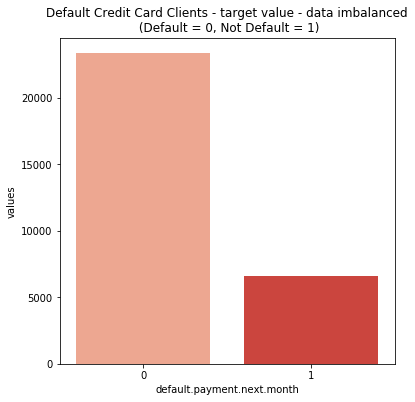

In [3]:
temp = df_credit_card["default.payment.next.month"].value_counts()
df = pd.DataFrame({'default.payment.next.month': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Clients - target value - data imbalanced\n (Default = 0, Not Default = 1)')
# sns.set_color_codes("pastel")
sns.barplot(x = 'default.payment.next.month', y="values", data=df, palette="Reds")
sns.color_palette('hls',10)
locs, labels = plt.xticks()
plt.savefig("./results/target_heatmap")

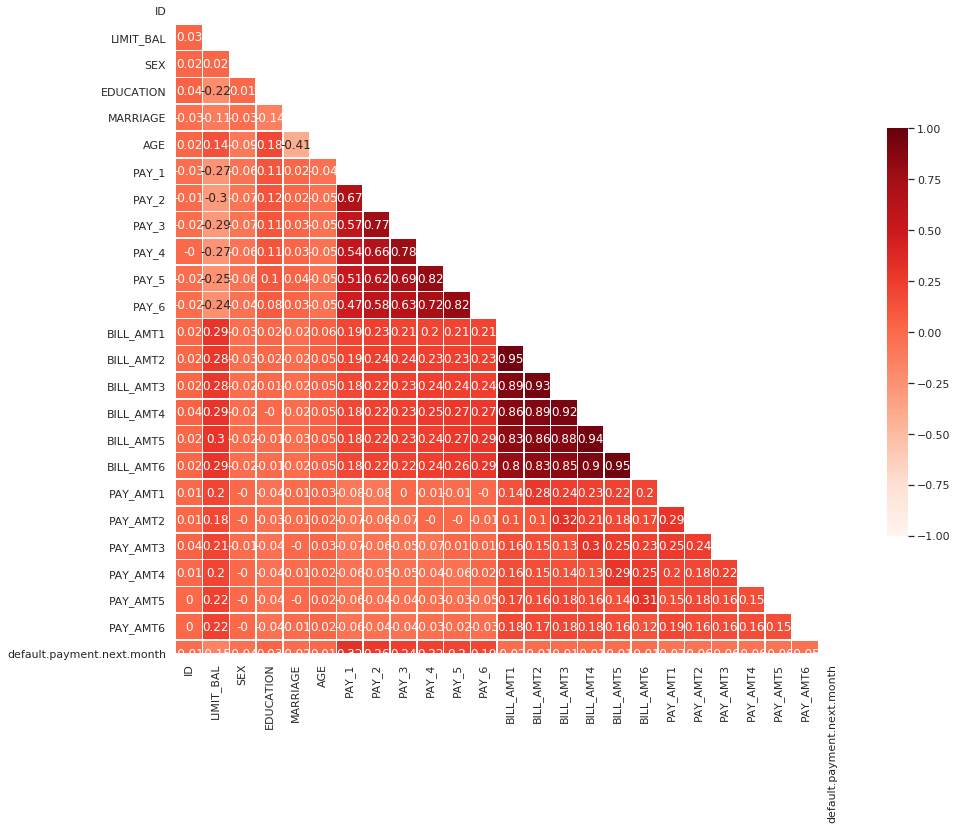

In [4]:
# heatmap for all countries
correlation_all = round(df_credit_card.corr(),2)
#print(correlation)

sns.set(style="white")
mask = np.zeros_like(correlation_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 15))
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

heatmap_all = sns.heatmap(
              correlation_all, 
              mask = mask, 
              cmap = 'Reds', 
              vmin = -1.0,
              vmax = 1.0,
              linewidths = 0.5, 
              cbar_kws = {"shrink": 0.5},
              square = True,
              annot = True,)

heatmap_all = heatmap_all.get_figure()
heatmap_all.savefig("./results/heatmap_all.png")

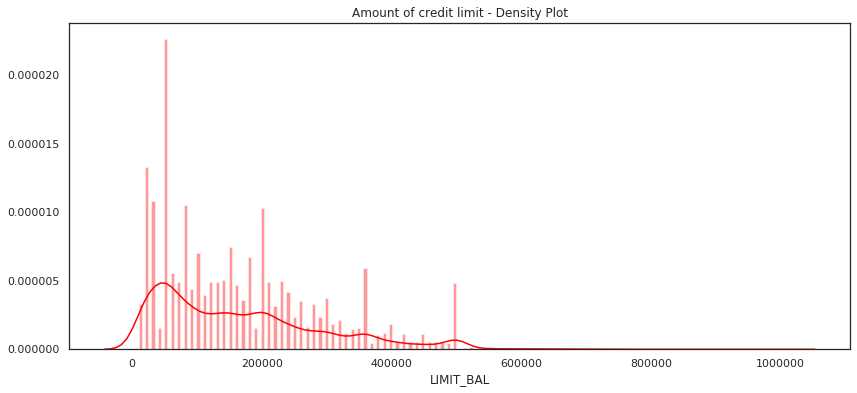

In [5]:
plt.figure(figsize = (14,6))
plt.title('Amount of credit limit - Density Plot')
sns.distplot(df_credit_card['LIMIT_BAL'],kde=True,bins=200, color="red")
plt.show()

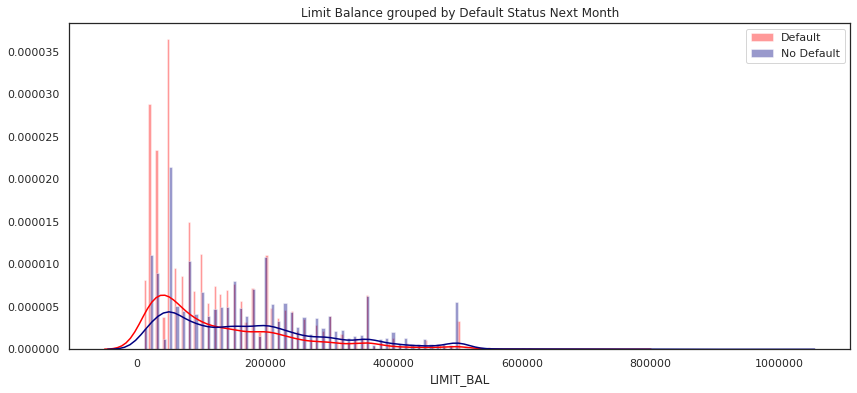

In [6]:
class_0 = df_credit_card.loc[df_credit_card['default.payment.next.month'] == 0]["LIMIT_BAL"]
class_1 = df_credit_card.loc[df_credit_card['default.payment.next.month'] == 1]["LIMIT_BAL"]
plt.figure(figsize = (14,6))
plt.title('Limit Balance grouped by Default Status Next Month')
#sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200,color="red")
sns.distplot(class_0,kde=True,bins=200,color="navy")
plt.legend(['Default','No Default'])
plt.savefig("./results/limit_balance_group_by_default")

### Dynamic Features

In [7]:
df_credit_card.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [34]:
def rnn_train_test_split(df, ratio):
    """
    split the train test df based on the ratio, ex: 0.8
    """
    length = len(df)
    idx = int(length*ratio)
    df_train = df.iloc[:idx,:]
    df_test = df.iloc[idx:,:]
    
    return df_train, df_test

In [35]:
df_train, df_test = rnn_train_test_split(df_credit_card, 0.8)

In [36]:
def organize_dynamic_feat(df):
    """
    orgainze dynamic features for each ID
    """
    
    dynamic_features = ['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                        'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
#                         'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                        'default.payment.next.month']
    
    #static_features = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE']
    
    df = df[dynamic_features]
    
    df_dynamic_all = []
    df_dynamic_label = []
    
    for row in range(len(df)):
        """
        for each ID
        """
        dynamic_feat_1 = df.iloc[row,0:6]
        dynamic_feat_2 = df.iloc[row,6:12]
#         dynamic_feat_3 = df.iloc[row,12:18]
        dynamic_feat_label = df.iloc[row,len(dynamic_features)-1] 
        
#         single_data = np.array([dynamic_feat_1, dynamic_feat_2, dynamic_feat_3]).reshape(-1,3)
        single_data = np.array([dynamic_feat_1, dynamic_feat_2]).reshape(-1,2) # only 2 dynamic feat
        single_label = np.array(dynamic_feat_label).reshape(-1,1)

#         df_single_data = pd.DataFrame(data=single_data, columns=['PAY','BILL_AMT', 'PAY_AMT'])
        df_single_data = pd.DataFrame(data=single_data, columns=['PAY','BILL_AMT']) # only 2 dynamic feat
        df_single_data_label = pd.DataFrame(data=single_label, columns=['label'])
        
        df_dynamic_all.append(df_single_data)
        df_dynamic_label.append(df_single_data_label)
    
    return df_dynamic_all, df_dynamic_label

In [37]:
df_dynamic_train, df_dynamic_train_label = organize_dynamic_feat(df_train)
df_dynamic_test, df_dynamic_test_label = organize_dynamic_feat(df_test)

In [38]:
def get_rnn_train_test(df_dynamic_train, df_dynamic_train_label, time_step):
    """
    get the training dataset and testing dataset for rnn
    """
 
    x_train_rnn = []
    y_train_rnn = []

    col_len = 2 # number of dynamice features
    
    for num in range(len(df_dynamic_train)):
        """
        for each ID
        """
        for row in range(0, len(df_dynamic_train[num])-time_step):
            x_train_rnn.append(df_dynamic_train[num].iloc[row:(row+time_step),0:(col_len)].values.reshape(len(df_dynamic_train[num].iloc[:,0:(col_len)].columns)*time_step))
            y_train_rnn.append(df_dynamic_train_label[num].values)
    
    
    x_train_rnn = torch.from_numpy(np.array(x_train_rnn)).reshape(-1,col_len*time_step,1).type(torch.FloatTensor)
    y_train_rnn = torch.from_numpy(np.array(y_train_rnn)).view(-1,1).type(torch.FloatTensor)
  
    print(x_train_rnn.shape, y_train_rnn.shape)
    
    training_dataset = Data.TensorDataset(x_train_rnn, y_train_rnn)
    
    return training_dataset

In [39]:
training_dataset = get_rnn_train_test(df_dynamic_train, 
                                      df_dynamic_train_label,
                                      time_step = 4)

testing_dataset = get_rnn_train_test(df_dynamic_test, 
                                     df_dynamic_test_label,
                                     time_step = 4)

torch.Size([48000, 8, 1]) torch.Size([48000, 1])
torch.Size([12000, 8, 1]) torch.Size([12000, 1])


In [40]:
training_loader = Data.DataLoader(
    dataset = training_dataset,
    shuffle = True,
    batch_size = 256,                    
    num_workers = 4,              
)

testing_loader = Data.DataLoader(
    dataset = testing_dataset,
    shuffle = True,
    batch_size = 256,      
    num_workers = 4,            
)

In [47]:
class history_package():
    def __init__(self, neural_net, train_loader, test_loader, EPOCH, LR, model_type):
        
        self.net = neural_net
        self.optimizer = torch.optim.Adam(neural_net.parameters(), lr = LR)
        
        pos_weight = torch.tensor([4]).to(device) # solve the imbalance data problem
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.EPOCH_ = EPOCH
        self.LR_ = LR
        self.net = self.net.to(device)
        self.model_type = model_type
        
        self.training_acc = []
        self.testing_acc = []
        
        if device == 'cuda':
            torch.backends.cudnn.benchmark = True

    def start(self):

        train_loss_list = []
        test_loss_list = []
        
        for epoch in range(self.EPOCH_):
            
            if epoch % 10 == 0:
                print("============================")
                print('Epoch:', epoch)
                

            train_loss = self.train(epoch)
            test_loss = self.test(epoch)

            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)
        
        return train_loss_list, test_loss_list, self.training_acc, self.testing_acc

    def train(self, epoch):
        
        self.net.train()
        train_loss = 0
        correct = 0
        total = 0
        
        
        for step, (batch_X, batch_y) in enumerate(self.train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            self.optimizer.zero_grad()
            outputs = self.net(batch_X)
            
            
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()      
            
            predicted = (outputs >= 0.5) 
            total += batch_y.size(0)
            correct += predicted.eq(batch_y).sum().item()
            
        self.training_acc.append(100.*(correct/total))

        if epoch % 10 == 0:
            print('【Training】Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss, 100.*(correct/total), correct, total))
        
        # save the model
        
        if self.model_type == "LSTM":
            torch.save(self.net.state_dict(), './model/LSTM_model.pth')
        
        if self.model_type == "LSTM_pos_weight":
            torch.save(self.net.state_dict(), './model/LSTM_model_pos_weight.pth')
            

        return train_loss
    
    def test(self, epoch):
        
        self.net.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad(): 
            for step, (batch_X, batch_y) in enumerate(self.test_loader):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = self.net(batch_X)
                
                loss = self.criterion(outputs, batch_y)
                
                test_loss += loss.item()
                
                predicted = (outputs >= 0.5)
                total += batch_y.size(0)
                correct += predicted.eq(batch_y).sum().item()                
        
        self.testing_acc.append(100.*(correct/total))

        if epoch % 10 == 0:
            print('【Testing】Loss: %.3f | Acc: %.3f%% (%d/%d)' % ( test_loss, 100.*(correct/total), correct, total ))
            
        
        return test_loss

In [48]:
# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):        
        out, _ = self.lstm(x, None)
        out = self.fc(out[:, -1, :])
        prob = F.sigmoid(out)
        
        return prob
    

In [ ]:
start_time = time.time()

rnn_module = history_package(LSTM(input_dim=1,
                                  hidden_dim=512,
                                  num_layers=2,
                                  output_dim=1), 
                             training_loader, 
                             testing_loader, 
                             EPOCH=1000, 
                             LR=0.00001,
                             model_type = "LSTM_pos")

history_train_loss, history_test_loss, history_train_acc, history_test_acc = rnn_module.start()

end_time = time.time()
print('Training Time Cost: ',time.strftime("%H hr %M min %S sec", time.gmtime(end_time - start_time)))

Epoch: 0
【Training】Loss: 219.005 | Acc: 76.100% (36528/48000)
【Testing】Loss: 53.371 | Acc: 78.900% (9468/12000)
Epoch: 10
【Training】Loss: 199.837 | Acc: 78.471% (37666/48000)
【Testing】Loss: 48.801 | Acc: 80.383% (9646/12000)
Epoch: 20
【Training】Loss: 199.797 | Acc: 78.533% (37696/48000)
【Testing】Loss: 48.783 | Acc: 80.158% (9619/12000)
Epoch: 30
【Training】Loss: 199.725 | Acc: 78.367% (37616/48000)
【Testing】Loss: 48.781 | Acc: 80.383% (9646/12000)
Epoch: 40
【Training】Loss: 199.727 | Acc: 78.300% (37584/48000)
【Testing】Loss: 48.784 | Acc: 80.492% (9659/12000)
Epoch: 50
【Training】Loss: 199.697 | Acc: 78.327% (37597/48000)
【Testing】Loss: 48.770 | Acc: 80.200% (9624/12000)
Epoch: 60
【Training】Loss: 199.651 | Acc: 78.498% (37679/48000)
【Testing】Loss: 48.790 | Acc: 80.175% (9621/12000)
Epoch: 70
【Training】Loss: 199.656 | Acc: 78.350% (37608/48000)
【Testing】Loss: 48.777 | Acc: 80.408% (9649/12000)
Epoch: 80
【Training】Loss: 199.643 | Acc: 78.356% (37611/48000)
【Testing】Loss: 48.765 | Acc: 80.20

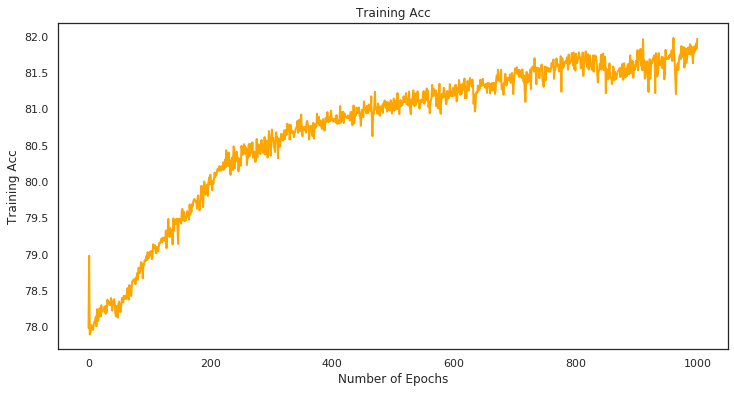

In [394]:
plt.figure(figsize=(12,6))
plt.plot(history_train_acc, color='orange', lw=2)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Acc")
plt.title("Training Acc")
#plt.savefig("./results/lstm_training_acc_pos")

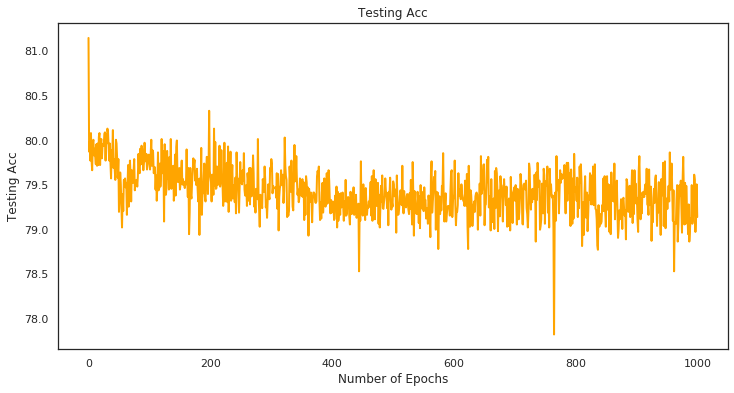

In [395]:
plt.figure(figsize=(12,6))
plt.plot(history_test_acc, color='orange', lw=2)
plt.xlabel("Number of Epochs")
plt.ylabel("Testing Acc")
plt.title("Testing Acc")
plt.savefig("./results/lstm_testing_acc_pos")

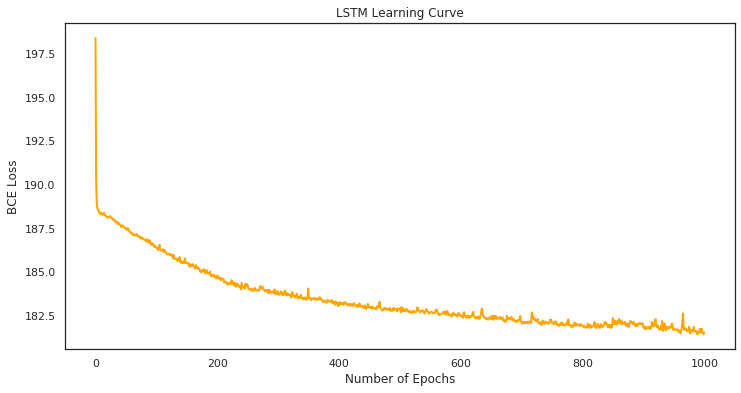

In [396]:
plt.figure(figsize=(12,6))
plt.plot(history_train_loss, color='orange', lw=2)
plt.xlabel("Number of Epochs")
plt.ylabel("BCE Loss")
plt.title("LSTM Learning Curve")
plt.savefig("./results/lstm_learning_curve_pos")

In [ ]:
# Here we define our model as a class
class LSTM_with_static(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):        
        out, _ = self.lstm(x, None)
        latent = self.fc(out[:, -1, :])
        
        
        return prob
    